# Resources
- [Interpretability in PyTorch Lightning with Captum. Explainable AI Tutorial](https://youtu.be/sub-0ZE5Xoo)

#Config

In [1]:
!pip install pytorch-lightning
!pip install captum

In [2]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset

from captum.attr import IntegratedGradients
from pytorch_lightning import seed_everything
from pytorch_lightning import Trainer

# Visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Utils
from enum import Enum
from sklearn.metrics import classification_report

# Data Loader

In [3]:
df = pd.read_csv("/content/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Training

In [27]:
# Enum for organizing
class TrainType(Enum):
  train = 1
  test = 2

# Custom Dataset for Torch Train
class RMSTitanic(Dataset):
  def __init__(self, type: TrainType, df=None):
    # Preprocessing
    df = df.copy()
    # Select relevant fields
    df = df[["Survived", "Pclass", "Sex", "Age", "SibSp", "Fare"]]
    # Convert Sex -> 0/1
    m = {"male": 0, "female": 1}
    df["Sex"] = df["Sex"].str.lower().map(m)
    # Fix non-available vals and normalize
    df = df.fillna(df.median())
    df -= df.min()
    df /= df.max()
    # The first 80% is train
    if type == TrainType.train:
      self.df = df.loc[:int(len(df) * 0.8)].copy()
    if type == TrainType.test:
      self.df = df.loc[int(len(df) * 0.8):].copy()
    # Using this later for interpretation
    self.base = torch.tensor(df[["Pclass", "Sex", "Age", "SibSp", "Fare"]].mean()).cuda()

  def __len__(self):
    return len(self.df)

  def __getitem__(self, item):
    """ This function returns the i-th element"""
    row = self.df.iloc[item]
    label = row.iloc[0] # Access label by position
    features = row.iloc[1:] # Access features by position
    # return the (features, labels)
    return (
        torch.tensor(features).cuda().float(),
        torch.tensor(label).cuda().float()
    )

In [28]:
RMSTitanic(TrainType.train,df)[0]

/tmp/ipython-input-1035647313.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.base = torch.tensor(df[["Pclass", "Sex", "Age", "SibSp", "Fare"]].mean()).cuda()
/tmp/ipython-input-1035647313.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(features).cuda().float(),


(tensor([1.0000, 0.0000, 0.2712, 0.1250, 0.0142], device='cuda:0'),
 tensor(0., device='cuda:0'))

## PyTorch Lightning Module

In [29]:
class plmodule(pl.LightningModule):
  def __init__(self):
    # Setting up model
    super().__init__()
    self.df = df
    self.lr = 0.01
    self.batch_size = 512
    l1 = 128

    # Sending first 5 features into first layer
    self.input = torch.nn.Linear(5, l1)
    # PRELU Activation function
    self.r1 = torch.nn.PReLU()
    # More Layers
    self.l1 = torch.nn.Linear(l1, l1)
    self.r2 = torch.nn.PReLU()
    self.out = torch.nn.Linear(l1, 1)
    # Before the output use a sigmoid
    self.sigmoid = torch.nn.Sigmoid()
    # Define Loss
    self.criterion = torch.nn.BCELoss()

  def forward(self, x):
    x = self.input(x)
    x = self.l1(x)
    x = self.r1(x)
    x = self.out(x)
    x = self.r2(x)
    x = self.sigmoid(x)
    return x

  def train_dataloader(self):
    # Load our Dataset: TRAIN
    return DataLoader(RMSTitanic(type=TrainType.train, df=self.df),
                      batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    # Load our Dataset: TEST
    # Simplification: TEST = VAL
    return DataLoader(RMSTitanic(type=TrainType.test, df=self.df),
                      batch_size = self.batch_size, shuffle=False)

  def configure_optimizers(self):
    # Optimizer
    return torch.optim.Adam(self.parameters(), lr=self.lr)

  def training_step(self, batch, batch_idx):
    x,y = batch
    y_hat = self(x)
    y = torch.reshape(y, (y.size()[0],1))
    loss = self.criterion(y_hat, y)
    tensorboard_logs = {"loss": loss}
    return {"loss": loss, "log": tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    y = torch.reshape(y, (y.size()[0], 1))
    loss = self.criterion(y_hat, y)
    return {"val_loss": loss}

In [33]:
max_epoch = 20

# Seed for reproduction
seed_everything(404)
# Load Model for GPU
device = torch.device("cuda")
model = plmodule().to(device)

# Trainer
trainer = Trainer(max_epochs=max_epoch, min_epochs=1)
trainer.fit(model)
# Accuracy
ts = RMSTitanic(TrainType.test, df)
x = torch.stack(
    [ts.__getitem__(i)[0] for i in range(ts.__len__())]
    )
x = x.to(device) # Move x to the GPU
y = torch.stack(
    [ts.__getitem__(i)[1] for i in range(ts.__len__())]
    ).cpu().detach().numpy()
y_hat = model.forward(x).cpu().detach().numpy()
y_hat = (y_hat >0.5)
print("Report:\n", classification_report(y, y_hat))

ts = RMSTitanic(TrainType.test, df)

INFO:lightning_fabric.utilities.seed:Seed set to 404
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | input     | Linear  | 768    | train
1 | r1        | PReLU   | 1      | train
2 | l1        | Linear  | 16.5 K | train
3 | r2        | PReLU   | 1      | train
4 | out       | Linear  | 129    | train
5 | sigmoid   | Sigmoid | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipython-input-1035647313.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.base = torch.tensor(df[["Pclass", "Sex", "Age", "SibSp", "Fare"]].mean()).cuda()
/tmp/ipython-input-1035647313.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(features).cuda().float(),
/tmp/ipython-input-1035647313.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.base = torch.tensor(df[["Pclass", "Sex", "Age", "SibSp", 

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipython-input-1035647313.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(features).cuda().float(),


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/tmp/ipython-input-1035647313.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.base = torch.tensor(df[["Pclass", "Sex", "Age", "SibSp", "Fare"]].mean()).cuda()
/tmp/ipython-input-1035647313.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(features).cuda().float(),


RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

#IG Captum Implementation

In [44]:
STEP_AMOUNT = 50
SAMPLE_DIM = 5

# Wrapper Class to fit PyTorch Lightning to Captum
def modified_f(in_vec):
  #Changes the shapes correctly
  # X: Shape([SAMPLE_DIM*STEP_AMOUNT]= 250)
  x = torch.reshape(in_vec, (int(
      in_vec.size()[0]/SAMPLE_DIM), SAMPLE_DIM
  ))
  # Ensure x is on the same device as the model and has the correct dtype
  x = x.to(model.device).float()
  #RES: Shape([50,5]) since we have 50 batches and 5 features
  res = model.forward(x)
  res = torch.reshape(res,(
      res.size()[0],1
  ))
  return res

ig = IntegratedGradients(modified_f)

# Test to understand basics
# First get the 6th test example
val = ts.__getitem__(6)[0]
print("IN X1:", val)
# Predict the importance of the features
# For male example
imp_m = ig.attribute(
    val.to(model.device).float(), # Move input to model's device and cast to float
    ts.base.to(model.device).float(), # Move baseline to model's device and cast to float
    n_steps = STEP_AMOUNT
)
print("Importance X_m:", imp_m)
print("Probability survival X_m:", modified_f(val.to(model.device).float()))
 # Predict the importance of the features
# For female example
print("Change gender to -> X2")
val_f = val.clone() # Create a copy to avoid modifying the original tensor
val_f[1] = 1 # Change gender to female (assuming 1 represents female based on preprocessing)
imp_f = ig.attribute(val_f.to(model.device).float(), ts.base.to(model.device).float(), n_steps = STEP_AMOUNT)
print("Importance X_f:", imp_f)
print("Probability survival X_f:", modified_f(val_f.to(model.device).float()))

IN X1: tensor([1.0000, 0.0000, 0.3466, 0.0000, 0.0303], device='cuda:0')
Importance X_m: tensor([-0.0846, -0.1074,  0.0033,  0.0143,  0.0003])
Probability survival X_m: tensor([[0.1501]], grad_fn=<ViewBackward0>)
Change gender to -> X2
Importance X_f: tensor([-0.1619,  0.3798,  0.0058,  0.0270,  0.0007])
Probability survival X_f: tensor([[0.5739]], grad_fn=<ViewBackward0>)


/tmp/ipython-input-1035647313.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(features).cuda().float(),


In [45]:
to_be_df=[]
# Compare each element of the test set to out baselines
# we will than use this
for i in range(0,ts.__len__()):
  # load our test example
  in_val = ts.__getitem__(i)[0]
  # compare it to the 4 baselines
  att_b = ig.attribute(
            inputs=in_val,
            baselines=ts.base,
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
  att_r = ig.attribute(
            inputs=in_val,
            baselines=torch.rand(
                5).cuda(),
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
  att_z = ig.attribute(
            inputs=in_val,
            baselines=torch.zeros(
                5).cuda(),
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
  att_1 = ig.attribute(
            inputs=in_val,
            baselines=torch.ones(
                5).cuda(),
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
  # save result, this will produce a df
  # you can skip the details
  for base_type, vals in [
            ("mean-base", att_b),
            ("random-base", att_r),
            ("zero-base", att_z),
            ('one-base', att_1),
  ]:
    for i, name in enumerate(['Pclass',
                                      "Sex",
                                      "Age",
                                      "SibSp",
                                      "Fare"]):
      to_be_df.append({
                    "base-type": base_type,
                    "feature": name,
                    "value": vals[i],
                    "epoch": max_epoch
                })


/tmp/ipython-input-1035647313.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(features).cuda().float(),


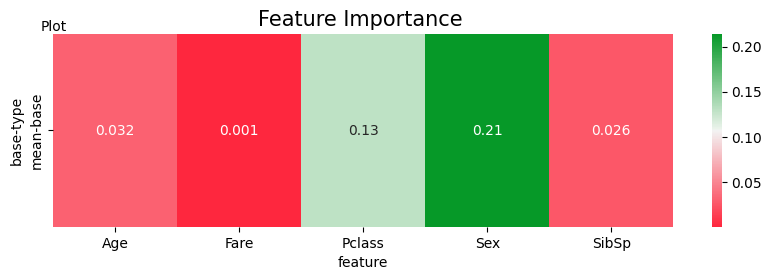

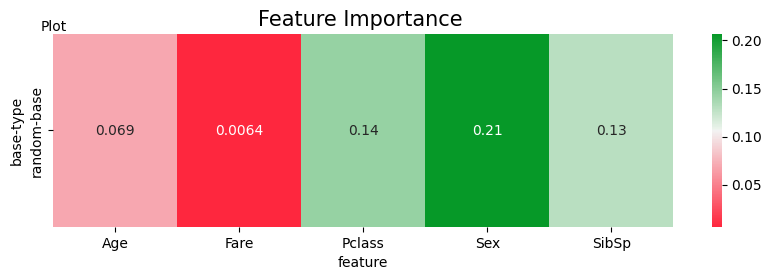

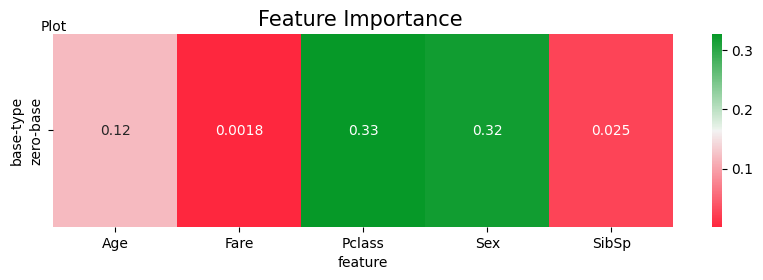

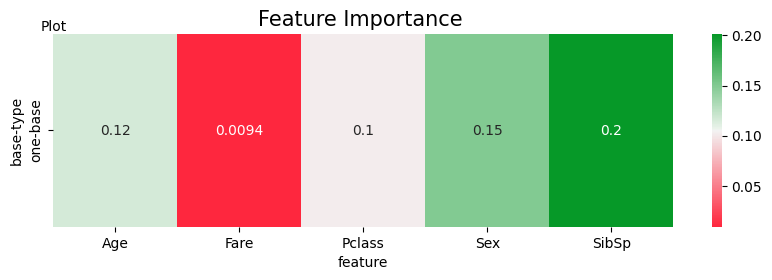

In [55]:
df_res=pd.DataFrame(to_be_df)
df_res.to_csv('/content/results/interpretation.csv')
# Aggregate and Visualize
# Load Data
# Defined the color map for our heatmap to be red to green
cmap = sns.diverging_palette(h_neg=10, h_pos=130, s=99,
                                 l=55, sep=3, as_cmap=True)
# Aggregate the CSV by mean
df_res = df.groupby(["base-type", 'feature', 'epoch'],
                    as_index=False).mean()
df_res= df_res[df_res['epoch'] == max_epoch]
# Make one plot per baseline to compare
for b in ["mean-base","random-base","zero-base",'one-base']:
  tmp = df_res[df_res['base-type'] == b]
  # Create a pivot frame
  tmp = tmp.pivot(index='base-type',columns='feature',values='value')
  # Some code to make a heatmap using seaborn
  fig, ax = plt.subplots()
  fig.set_size_inches(10, 2.5)
  plt.title("Feature Importance ", fontsize=15)
  sns.heatmap(tmp, ax=ax, cmap=cmap, annot=True)
  plt.text(0, 0,'Plot',horizontalalignment='center',verticalalignment='bottom',fontsize=10)